# Learning Curves

To assess applicability of various models
___

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.learning_curve import learning_curve
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

## Load data and divide into train/test

In [31]:
def formatdata(chunk):
    '''Format data of each startified chunk.'''
    
    # fill NAs for origin-destination distance
    chunk['orig_destination_distance'].fillna(0.0, inplace=True)
  
    # parse datetime objects
    for col in ['date_time', 'srch_ci', 'srch_co']:
        chunk[col] = pd.to_datetime(chunk[col], errors='coerce')
    # create booking dayofyear
    chunk['bookmonth'] = chunk['date_time'].apply(lambda x: x.month)
    # fill NA values with booking datetime and stay length of zero
    chunk['srch_co'].fillna(chunk['date_time'], inplace=True)
    chunk['srch_ci'].fillna(chunk['date_time'], inplace=True)
    # create stay length
    chunk['stay'] = chunk['srch_co']-chunk['srch_ci']
    chunk['stay'] = chunk['stay'].apply(lambda x: x.days)

    # create stay dayofyear
    chunk['staydoy'] = chunk['srch_ci'].apply(lambda x: x.dayofyear)
     
    # drop processed columns
    chunk.drop(['date_time','srch_ci','srch_co'], axis=1, inplace=True)
    
    return chunk

def stratshufspl(chunk, fraction, ylabel):
    '''Startified shuffle split of chunks.'''
    sss = StratifiedShuffleSplit(chunk[ylabel], test_size=fraction, 
                                 random_state=42, n_iter=1)
    for _, idx in sss:
        train = chunk.iloc[idx].copy()
    return train


def fractionate(trainiter, fraction, ylabel):
    '''Utilizes only one core.'''
    print('')
    print('loading data...')
    
    # create empty list and add formatted data chunks
    chunks = list()
    for chunk in trainiter:
        # if using whole dataset skip this step
        if fraction < 1.0:
            chunk = stratshufspl(chunk, fraction, ylabel)
        curr = formatdata(chunk)
        chunks.append(curr)
        
    # concatenate chunks
    train = pd.concat(chunks, axis=0)
    
    # split concatenated set into X and y for ml model fitting
    X = train.drop(ylabel, axis=1, inplace=False)
    y = train[ylabel]
    return X, y

In [32]:
dataurl = '/Users/dbricare/Documents/Python/datasets/expedia/'

rawcols = ['site_name', 'user_location_country', 'user_location_region', 
            'is_package', 'srch_adults_cnt', 'srch_children_cnt', 
            'srch_destination_type_id', 'orig_destination_distance', 'hotel_country', 
            'hotel_market', 'srch_ci', 'srch_co', 'date_time', 'hotel_cluster']

ylabel = rawcols[-1]

# csviter = pd.read_csv(dataurl+'train.csv.gz', sep=',', compression='gzip', chunksize=2000000, usecols=rawcols)
csviter = pd.read_csv(dataurl+'train200th.csv', sep=',', chunksize=200000, usecols=rawcols)


X, y = fractionate(csviter, 1.0, rawcols[-1])

print(X.shape)
print(X.columns)
X.head()


loading data...
(188351, 13)
Index(['site_name', 'user_location_country', 'user_location_region',
       'orig_destination_distance', 'is_package', 'srch_adults_cnt',
       'srch_children_cnt', 'srch_destination_type_id', 'hotel_country',
       'hotel_market', 'bookmonth', 'stay', 'staydoy'],
      dtype='object')


,site_name,user_location_country,user_location_region,orig_destination_distance,is_package,srch_adults_cnt,srch_children_cnt,srch_destination_type_id,hotel_country,hotel_market,bookmonth,stay,staydoy
0,18,231,68,0.0000,1,4,0,6,105,29,2,2,89
1,13,46,171,5763.2976,0,2,0,1,203,253,10,7,339
2,2,66,220,188.2171,0,3,0,1,50,682,8,3,266
3,34,205,155,60.4896,0,2,0,1,198,401,11,1,326
4,2,66,435,4362.4117,0,2,0,1,204,27,6,3,192


## Create sparse matrix

In [37]:
notcats = ['orig_destination_distance','stay', 'is_package']
cats = list(X.columns)
for cat in notcats:
    cats.remove(cat)
#for col in cats:
    
print('expected number of columns in sparse matrix:', X[cats].max().sum()+len(X.columns))

catdict = OrderedDict()
for col in X.columns:
    if col in notcats:
        val = False
    else:
        val = True
    catdict.update({col:val})

maxfeatures = [54, 240, 1028, 10, 10, 10, 213, 2118, 13, 367]
mask = np.array(list(catdict.values()))

enc = OneHotEncoder(n_values=maxfeatures, categorical_features=mask, dtype=int, sparse=True)

Xsparse = enc.fit_transform(X.values)
print('all features:',sum(maxfeatures)+3)
print('sparse matrix shape:', Xsparse.shape)
print('total encoding values:', sum(enc.n_values)) 

expected number of columns in sparse matrix: 4065
all features: 4060
sparse matrix shape: (188351, 4060)
total encoding values: 4057


In [38]:
params = {'class_weight': 'balanced', 'n_estimators': 150, 'max_depth': 16, 'max_features': 0.2}

estimator = RandomForestClassifier(random_state=42, n_jobs=2)
estimator.set_params(**params)
scorer = 'log_loss'
datarange = np.linspace(0.1, 1, 5)

train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, 
                                                        X=Xsparse,
                                                        y=y, 
                                                        train_sizes=datarange, 
                                                        cv=3,
                                                        scoring=scorer,
                                                        n_jobs=2)

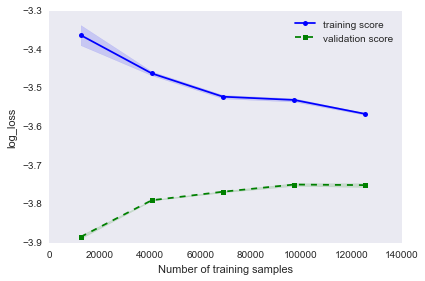

In [39]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training score')

plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std, 
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation score')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel(scorer)
plt.legend(loc='best')
# plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('learning_curve.png', dpi=300)
plt.show()

Ideally, log loss is maximized if all the predicted probabilities are high when predicting 1 or low when predicting 0. Thus we want to increase the validation score to a high value, close to the training score.

This graph suggests increasing the number of training samples could improve the validation(test) error. 

Also, there is a significant gap between validation and training error suggesting there is significant variance (model is closely following training data but does not generalize well).